### Downloading the Price datasets

#### Prices from Investing.com
BTC: https://www.investing.com/crypto/bitcoin/historical-data <br>
ETH: https://www.investing.com/crypto/ethereum/historical-data <br>
SOL: https://www.investing.com/crypto/solana/historical-data <br>
SNP500: https://www.investing.com/indices/us-spx-500-historical-data <br>
VIX: https://www.investing.com/indices/volatility-s-p-500-historical-data <br>
GOLD: https://www.investing.com/commodities/gold-historical-data

#### TVL from DeFi Lama
BTC: https://defillama.com/chain/Bitcoin <br>
ETH: https://defillama.com/chain/Ethereum <br>
SOL: https://defillama.com/chain/Solana

#### Wikipedia Page Views
ALL: https://pageviews.wmcloud.org/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. Removing the Comma from the price action 
def comma_form(column): 
    column = column.str.replace(',', '')
    column = pd.to_numeric(column, errors='coerce')
    return column

# 2. Converting the Volume Function 
def convert_volume(volume):
    # Check if the value is a string and needs conversion
    if isinstance(volume, str):
        factor = 1
        if volume.endswith('K'):
            factor = 10**3
        elif volume.endswith('M'):
            factor = 10**6
        elif volume.endswith('B'):
            factor = 10**9
        # Remove the last character and convert to float
        return float(volume[:-1]) * factor
    else:
        # If not a string, return as is (assuming it's already a numeric type)
        return volume
    
# 3. Adjusting the Change % Column 
def percent(percent):
    return pd.to_numeric(percent.str.replace('%', '')) / 100

# 4. Date Selection
def date_filter(df, start_date_str, end_date_str):
    # Convert start and end date strings to datetime
    start_date = pd.to_datetime(start_date_str, dayfirst=True)
    end_date = pd.to_datetime(end_date_str, dayfirst=True)

    # Filter based on the date range
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    return df.loc[mask]

# 5. Apply Filter
def apply_filter(df, apply_comma_form=True, apply_convert_volume=True, apply_percent=True, start_date_str=None, end_date_str=None):
    df.Date = pd.to_datetime(df.Date)

    if apply_convert_volume:
        if 'Vol.' in df.columns:
            df['Volume'] = df['Vol.'].apply(convert_volume)

    if apply_percent:
        if 'Change %' in df.columns:
            df['Change %'] = percent(df['Change %'])

    if apply_comma_form:
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = comma_form(df[col])
                       
    if start_date_str and end_date_str:
        df = date_filter(df, start_date_str, end_date_str)
    df = df[['Date', 'Price', 'Change %', 'Open', 'High', 'Low', 'Volume']]    
    return df

### Prepare Pricing Data

In [2]:
btc = pd.read_csv('data/price/btc.csv')
eth = pd.read_csv('data/price/eth.csv')
sol = pd.read_csv('data/price/sol.csv')

btc = apply_filter(btc)
sol = apply_filter(sol, apply_comma_form=False)
eth = apply_filter(eth, apply_comma_form=False)

#### Adding in reddit_sentiment data

In [3]:
btc_reddit = pd.read_csv('data/model/btc_reddit_sen.csv')
btc_reddit = btc_reddit[['date_posted', 'weighted_sentiment']]
btc_reddit.date_posted = pd.to_datetime(btc_reddit.date_posted)
btc = pd.merge(btc, btc_reddit, left_on='Date', right_on='date_posted', how='left')

def fill_missing_with_avg(df, column):
    data = df[column].copy()
    n = len(data)
    
    for i in range(1, n-1):
        if pd.isnull(data[i]):
            if pd.notnull(data[i-1]) and pd.notnull(data[i+1]) and pd.isnull(data[i+1:i+2]).sum() == 0:
                data[i] = (data[i-1] + data[i+1]) / 2

    df[column] = data
    return df

btc = fill_missing_with_avg(btc, 'weighted_sentiment')

btc

,Date,Price,Change %,Open,High,Low,Volume,date_posted,weighted_sentiment
0,2024-06-30,61556.4,0.0096,60973.1,61807.2,60703.7,26840.0,2024-06-30,0.849462
1,2024-06-29,60973.4,0.0094,60403.7,61192.8,60382.8,26560.0,2024-06-29,-0.239932
2,2024-06-28,60403.3,-0.0208,61684.6,62175.4,60081.9,58950.0,2024-06-28,0.241396
3,2024-06-27,61685.3,0.0137,60848.3,62351.2,60629.4,48790.0,2024-06-27,0.335465
4,2024-06-26,60849.4,-0.0155,61809.9,62469.4,60715.1,54950.0,2024-06-26,0.220186
...,...,...,...,...,...,...,...,...,...
542,2023-01-05,16829.8,-0.0013,16852.2,16877.9,16772.3,178960.0,NaT,NaN
543,2023-01-04,16852.1,0.0107,16674.2,16976.5,16656.5,247390.0,NaT,NaN
544,2023-01-03,16674.2,0.0000,16673.1,16773.2,16607.2,178730.0,NaT,NaN
545,2023-01-02,16674.3,0.0034,16618.4,16766.9,16551.0,136030.0,NaT,NaN


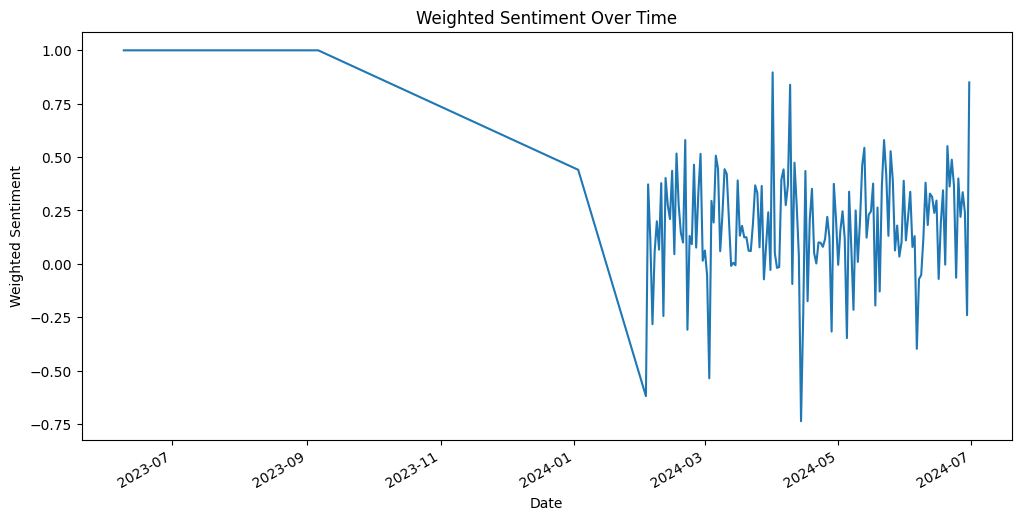

In [4]:
extt = btc.copy()
extt = extt.dropna()
# Convert 'Date' column to datetime
extt['Date'] = pd.to_datetime(extt['Date'])

# Set 'Date' as the index
extt.set_index('Date', inplace=True)

# Plot 'weighted_sentiment' with 'Date' as x-axis
plt.figure(figsize=(12, 6))  # Set the figure size to make the plot wider
extt['weighted_sentiment'].plot()
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Weighted Sentiment Over Time')
plt.show()

#### Adding Wikipedia Page Views and Google Trends Data

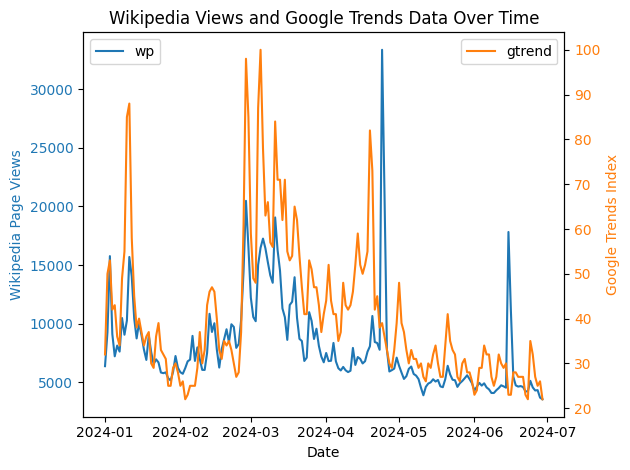

In [7]:
btc_wp = pd.read_csv('data/ext/btc_wp.csv')
btc_gtrends = pd.read_csv('data/ext/btc_gtrends.csv')

eth_wp = pd.read_csv('data/ext/eth_wp.csv')
eth_gtrends = pd.read_csv('data/ext/eth_gtrends.csv')

sol_wp = pd.read_csv('data/ext/sol_wp.csv')
sol_gtrends = pd.read_csv('data/ext/sol_gtrends.csv')


btc_gtrends, eth_gtrends, sol_gtrends = btc_gtrends[1:], eth_gtrends[1:], sol_gtrends[1:] # Only select rows after the 1st one 
btc_gtrends['Date'], eth_gtrends['Date'], sol_gtrends['Date'] = btc_gtrends.index, eth_gtrends.index, sol_gtrends.index # Convert the indexes to Date column

btc_wp.rename(columns={'Bitcoin': 'Wikipedia_Views'}, inplace=True)
btc_gtrends.rename(columns={'Category: All categories': 'Google_Trends'}, inplace=True)

eth_wp.rename(columns={'Ethereum': 'Wikipedia_Views'}, inplace=True)
eth_gtrends.rename(columns={'Category: All categories': 'Google_Trends'}, inplace=True)

sol_wp.rename(columns={'Solana': 'Wikipedia_Views'}, inplace=True)
sol_gtrends.rename(columns={'Category: All categories': 'Google_Trends'}, inplace=True)


btc_gtrends.Date, eth_gtrends.Date, sol_gtrends.Date = pd.to_datetime(btc_gtrends.Date), pd.to_datetime(eth_gtrends.Date), pd.to_datetime(sol_gtrends.Date)
btc_wp.Date, eth_wp.Date, sol_wp.Date = pd.to_datetime(btc_wp.Date), pd.to_datetime(eth_wp.Date), pd.to_datetime(sol_wp.Date)

ext_b, ext_e, ext_s = pd.merge(btc_wp, btc_gtrends, on='Date', how='left'), pd.merge(eth_wp, eth_gtrends, on='Date', how='left'), pd.merge(sol_wp, sol_gtrends, on='Date', how='left')
ext_b['Google_Trends'], ext_e['Google_Trends'], ext_s['Google_Trends'] = ext_b['Google_Trends'].astype(float), ext_e['Google_Trends'].astype(float), ext_s['Google_Trends'].astype(float)
btc, eth, sol = pd.merge(btc, ext_b), pd.merge(eth, ext_e), pd.merge(sol, ext_s) # Merging ext data to main df

# Create the plot
fig, ax1 = plt.subplots()

# Plot 'wp' on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Wikipedia Page Views', color='tab:blue')
ax1.plot(ext_b['Date'], ext_b['Wikipedia_Views'], color='tab:blue', label='wp')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for 'gtrend'
ax2 = ax1.twinx()
ax2.set_ylabel('Google Trends Index', color='tab:orange')
ax2.plot(ext_b['Date'], ext_b['Google_Trends'], color='tab:orange', label='gtrend')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Wikipedia Views and Google Trends Data Over Time')
fig.tight_layout()  # To ensure the labels do not overlap

# Show the plot
plt.show()

In [8]:
btc

,Date,Price,Change %,Open,High,Low,Volume,date_posted,weighted_sentiment,Wikipedia_Views,Google_Trends
0,2024-06-29,60973.4,0.0094,60403.7,61192.8,60382.8,26560.0,2024-06-29,-0.239932,3549,22.0
1,2024-06-28,60403.3,-0.0208,61684.6,62175.4,60081.9,58950.0,2024-06-28,0.241396,3687,26.0
2,2024-06-27,61685.3,0.0137,60848.3,62351.2,60629.4,48790.0,2024-06-27,0.335465,4327,25.0
3,2024-06-26,60849.4,-0.0155,61809.9,62469.4,60715.1,54950.0,2024-06-26,0.220186,4297,27.0
4,2024-06-25,61809.4,0.0252,60292.0,62266.0,60262.2,77280.0,2024-06-25,0.399863,4558,32.0
...,...,...,...,...,...,...,...,...,...,...,...
176,2024-01-05,44156.9,0.0000,44163.0,44312.1,42629.0,68070.0,NaT,NaN,7212,43.0
177,2024-01-04,44157.0,0.0308,42836.1,44744.5,42632.8,68050.0,NaT,NaN,9113,42.0
178,2024-01-03,42836.1,-0.0469,44943.7,45492.7,40888.3,117650.0,2024-01-03,0.440400,15761,53.0
179,2024-01-02,44943.7,0.0172,44182.9,45885.4,44166.0,97840.0,NaT,NaN,9267,50.0


#### Adding the TVL Data

In [9]:
btc_tvl = pd.read_csv('data/tvl/btc_tvl.csv')
eth_tvl = pd.read_csv('data/tvl/eth_tvl.csv')
sol_tvl = pd.read_csv('data/tvl/sol_tvl.csv')

def tvl_pro(df):
    df = df[:1]
    df = df.melt(var_name='Date', value_name='TVL')
    df = df.drop(index=0).reset_index(drop=True)
    df.Date = pd.to_datetime(df.Date, dayfirst=True)
    return df

btc_tvl, eth_tvl, sol_tvl = tvl_pro(btc_tvl), tvl_pro(eth_tvl), tvl_pro(sol_tvl)

btc, eth, sol = pd.merge(btc, btc_tvl, on='Date', how='left'), pd.merge(eth, eth_tvl, on='Date', how='left'), pd.merge(sol, sol_tvl, on='Date', how='left')

btc


,Date,Price,Change %,Open,High,Low,Volume,date_posted,weighted_sentiment,Wikipedia_Views,Google_Trends,TVL
0,2024-06-29,60973.4,0.0094,60403.7,61192.8,60382.8,26560.0,2024-06-29,-0.239932,3549,22.0,1004196509.156641
1,2024-06-28,60403.3,-0.0208,61684.6,62175.4,60081.9,58950.0,2024-06-28,0.241396,3687,26.0,1025230736.409645
2,2024-06-27,61685.3,0.0137,60848.3,62351.2,60629.4,48790.0,2024-06-27,0.335465,4327,25.0,1015541216.646057
3,2024-06-26,60849.4,-0.0155,61809.9,62469.4,60715.1,54950.0,2024-06-26,0.220186,4297,27.0,1035170175.628397
4,2024-06-25,61809.4,0.0252,60292.0,62266.0,60262.2,77280.0,2024-06-25,0.399863,4558,32.0,1001518353.133826
...,...,...,...,...,...,...,...,...,...,...,...,...
176,2024-01-05,44156.9,0.0000,44163.0,44312.1,42629.0,68070.0,NaT,NaN,7212,43.0,319142424.024755
177,2024-01-04,44157.0,0.0308,42836.1,44744.5,42632.8,68050.0,NaT,NaN,9113,42.0,309519348.463304
178,2024-01-03,42836.1,-0.0469,44943.7,45492.7,40888.3,117650.0,2024-01-03,0.440400,15761,53.0,325693087.810681
179,2024-01-02,44943.7,0.0172,44182.9,45885.4,44166.0,97840.0,NaT,NaN,9267,50.0,316328729.58009


#### Proccess Gold, SNP, and VIX Data

In [10]:
gold = pd.read_csv('data/price/gold.csv')
snp = pd.read_csv('data/price/snp.csv')
vix = pd.read_csv('data/price/vix.csv')

gold.Date, snp.Date, vix.Date = pd.to_datetime(gold.Date), pd.to_datetime(snp.Date), pd.to_datetime(vix.Date)

# 2. Applying the Comma function on Prices
gold.Price, snp.Price = comma_form(gold.Price), comma_form(snp.Price)
gold.Open, snp.Open = comma_form(gold.Open), comma_form(snp.Open)
gold.High, snp.High = comma_form(gold.High), comma_form(snp.High)
gold.Low, snp.Low= comma_form(gold.Low), comma_form(snp.Low)

# 3. Renaming Volume and applying fomatting
gold['Volume'], snp['Volume']= gold['Vol.'], snp['Vol.']
gold.Volume, snp.Volume = gold.Volume.apply(convert_volume), snp.Volume.apply(convert_volume)

# 4. Applying the PCT Change Column
gold['Change %'], snp['Change %'], vix['Change %']  = percent(gold['Change %']), percent(snp['Change %']), percent(vix['Change %'])
gold['pct_change'], snp['pct_change'], vix['pct_change'] = gold['Change %'], snp['Change %'], vix['Change %']

# 5. Deleting old formatted columns
gold, snp, vix = gold.drop(['Vol.', 'Change %'], axis = 1), snp.drop(['Vol.', 'Change %'], axis = 1), vix.drop(['Vol.', 'Change %'], axis = 1)

###### A function to fill in missing dates in Gold, SNP, and VIX prices from the previous column. This is because on the weekends the markets are closed

In [11]:
# Fill missing dates and prices
def fill_missing_data(df):
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index
    df.set_index('Date', inplace=True)

# Create a date range from the min to the max date in the DataFrame
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to the new date range
    df = df.reindex(date_range)

# Fill missing values by propagating the last valid observation forward
    df.fillna(method='ffill', inplace=True)

# Reset the index to get the date column back
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)
    
    return df

gold, snp, vix = fill_missing_data(gold), fill_missing_data(snp), fill_missing_data(vix)
gold

,Date,Price,Open,High,Low,Volume,pct_change
0,2023-01-16,1909.9,1923.8,1931.8,1906.2,268370.0,-0.0061
1,2023-01-17,1909.9,1923.8,1931.8,1906.2,268370.0,-0.0061
2,2023-01-18,1907.0,1911.1,1929.8,1898.6,218970.0,-0.0015
3,2023-01-19,1923.9,1907.0,1936.9,1902.0,214250.0,0.0089
4,2023-01-20,1928.2,1933.7,1939.0,1922.0,165270.0,0.0022
...,...,...,...,...,...,...,...
525,2024-06-24,2332.4,2322.1,2334.7,2318.0,600.0,0.0057
526,2024-06-25,2318.4,2334.4,2336.2,2314.8,1260.0,-0.0060
527,2024-06-26,2301.0,2318.8,2320.5,2292.9,990.0,-0.0075
528,2024-06-27,2336.6,2309.4,2342.0,2306.8,140230.0,0.0155


#### Merging Gold, SNP, and VIX Datatables

In [12]:
ext = pd.merge(gold, snp, on='Date')
ext = pd.merge(ext, vix, on='Date')

# Assuming df is your DataFrame
ext.rename(columns={
    'Price_x': 'Gold_Price',
    'Open_x': 'Gold_Open',
    'High_x': 'Gold_High',
    'Low_x': 'Gold_Low',
    'Volume_x': 'Gold_Volume',
    'pct_change_x': 'Gold_pct_change',
    'Price_y': 'SNP_Price',
    'Open_y': 'SNP_Open',
    'High_y': 'SNP_High',
    'Low_y': 'SNP_Low',
    'Volume_y': 'SNP_Volume',
    'pct_change_y': 'SNP_pct_change',
    'Price': 'VIX_Price',
    'Open': 'VIX_Open',
    'High': 'VIX_High',
    'Low': 'VIX_Low',
    'pct_change': 'VIX_pct_change'
}, inplace=True)

##### Creating the 'tomorrow' independent variable

In [13]:
def tomorrow(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date', ascending=False)
    df['Tomorrow'] = df.Price.shift(1)
    df['Tomorrow'] = (df.Tomorrow > df.Price).astype(int)
    return df

btc, eth, sol = tomorrow(btc), tomorrow(eth), tomorrow(sol)

##### Join Gold, SNP, and VIX to Crypto Price Dataset

In [14]:
def join_other(df):
    df = pd.merge(df, ext, on='Date', how='left')
    return df
btc_1, eth_1, sol_1 = join_other(btc), join_other(eth), join_other(sol)

##### Function to create the technical indicators

In [15]:
def technical_analysis(df):
    # Create a copy of the input DataFrame
    ta = df.copy()
    
    # 10D MA
    ta['MA'] = ta.Price.rolling(window=10).mean()
    ta['MA_td'] = (ta.Price > ta.MA).astype(int)
    
    # 30D MA
    ta['3MA'] = ta.Price.rolling(window=30).mean()
    ta['3MA_td'] = (ta.Price > ta['3MA']).astype(int)
    
    # %K
    lowest_low = ta.Low.rolling(window=10).min()
    highest_high = ta.High.rolling(window=10).max()
    ta['%K'] = (ta.Price - lowest_low) / (highest_high - lowest_low) * 100
    ta['%K_td'] = (ta['%K'] > ta['%K'].shift(1)).astype(int)
    
    # Calculate %D
    ta['%D'] = ta['%K'].rolling(window=3).mean()
    ta['%D_td'] = (ta['%D'] > ta['%D'].shift(1)).astype(int)
    
    # RSI 
    delta = ta.Price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    ta['RSI'] = 100 - (100 / (1 + rs))
    
    def RSI_td(rsi_values):
        if rsi_values >= 70:
            return -1
        elif rsi_values <= 30:
            return 1
        else:
            return 0
    
    ta['RSI_td'] = ta.RSI.apply(RSI_td)
    
    # Momentum 
    momentum_window = 10 
    ta['Momentum'] = ta.Price - ta.Price.shift(momentum_window)
    ta['Momentum_td'] = (ta.Momentum > 1).astype(int)
    
    # MACD 12,26,9
    ta['EMA12'] = ta.Price.ewm(span=12, adjust=False).mean()
    ta['EMA26'] = ta.Price.ewm(span=26, adjust=False).mean()
    ta['MACD'] = ta['EMA12'] - ta['EMA26']
    ta['Signal'] = ta['MACD'].ewm(span=9, adjust=False).mean()
    ta['MACD_td'] = (ta['MACD'] > ta['MACD'].shift(1)).astype(int)
    
    # CCI
    ta['TP'] = (ta['High'] + ta['Low'] + ta['Price']) / 3
    
    # Calculate the 20-period Simple Moving Average of the Typical Price
    ta['SMA_TP'] = ta['TP'].rolling(window=20).mean()
    
    def calculate_md(series):
        return abs(series - series.mean()).mean()
    
    ta['MD'] = ta['TP'].rolling(window=20).apply(calculate_md)
    
    # Calculate the CCI
    ta['CCI'] = (ta['TP'] - ta['SMA_TP']) / (0.015 * ta['MD'])
    
    def CCI_td(CCI_values):
        if CCI_values >= 100:
            return -1
        elif CCI_values <= -100:
            return 1
        else:
            return 0
    
    ta['CCI_td'] = ta.CCI.apply(CCI_td)

    ta = ta[['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %','TVL', 'weighted_sentiment',
       'Tomorrow', 'Gold_Price', 'Gold_Open', 'Gold_High', 'Gold_Low',
       'Gold_Volume', 'Gold_pct_change', 'SNP_Price', 'SNP_Open', 'SNP_High',
       'SNP_Low', 'SNP_Volume', 'SNP_pct_change', 'VIX_Price', 'VIX_Open',
       'VIX_High', 'VIX_Low', 'VIX_pct_change','MA_td','3MA_td',
       '%K_td','%D_td','RSI_td',
       'Momentum_td','MACD_td','CCI_td','Wikipedia_Views','Google_Trends']]

    return ta

In [16]:
#btcc, ethh, soll = technical_analysis(btc_1), technical_analysis(eth_1), technical_analysis(sol_1)
btcc = technical_analysis(btc_1)

Sample Dataset for BTC

In [17]:
btcc

,Date,Price,Open,High,Low,Volume,Change %,TVL,weighted_sentiment,Tomorrow,...,MA_td,3MA_td,%K_td,%D_td,RSI_td,Momentum_td,MACD_td,CCI_td,Wikipedia_Views,Google_Trends
0,2024-06-29,60973.4,60403.7,61192.8,60382.8,26560.0,0.0094,1004196509.156641,-0.239932,0,...,0,0,0,0,0,0,0,0,3549,22.0
1,2024-06-28,60403.3,61684.6,62175.4,60081.9,58950.0,-0.0208,1025230736.409645,0.241396,1,...,0,0,0,0,0,0,0,0,3687,26.0
2,2024-06-27,61685.3,60848.3,62351.2,60629.4,48790.0,0.0137,1015541216.646057,0.335465,0,...,0,0,0,0,0,0,1,0,4327,25.0
3,2024-06-26,60849.4,61809.9,62469.4,60715.1,54950.0,-0.0155,1035170175.628397,0.220186,1,...,0,0,0,0,0,0,0,0,4297,27.0
4,2024-06-25,61809.4,60292.0,62266.0,60262.2,77280.0,0.0252,1001518353.133826,0.399863,0,...,0,0,0,0,0,0,1,0,4558,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2024-01-05,44156.9,44163.0,44312.1,42629.0,68070.0,0.0000,319142424.024755,NaN,0,...,0,1,1,0,0,1,0,0,7212,43.0
177,2024-01-04,44157.0,42836.1,44744.5,42632.8,68050.0,0.0308,309519348.463304,NaN,0,...,0,1,0,1,0,1,0,0,9113,42.0
178,2024-01-03,42836.1,44943.7,45492.7,40888.3,117650.0,-0.0469,325693087.810681,0.440400,1,...,0,1,0,0,0,0,0,0,15761,53.0
179,2024-01-02,44943.7,44182.9,45885.4,44166.0,97840.0,0.0172,316328729.58009,NaN,0,...,0,1,1,1,0,1,1,0,9267,50.0


### Finalize Model Dataset

In [18]:
model_b = btcc[['Tomorrow', 'Date', 'Price', 'Change %','Volume', 'TVL',
       'weighted_sentiment', 'Gold_Volume','Gold_pct_change', 'SNP_Price',
       'SNP_Volume', 'SNP_pct_change',
       'VIX_Price', 'VIX_pct_change',
       'MA_td', '3MA_td', '%K_td', '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td',
       'CCI_td', 'Wikipedia_Views', 'Google_Trends']]

In [19]:
list = ['Volume', 'TVL','weighted_sentiment', 'Gold_Volume', 
       'SNP_Volume','VIX_pct_change','Wikipedia_Views', 'Google_Trends']

def calculate_percentage_change(df, column_names):
    for column in column_names:
        if column in df.columns:
            df[column + '_pct_change'] = df[column].pct_change() * 100
        else:
            print(f"Column '{column}' not found in DataFrame")
    return df

model_b = calculate_percentage_change(model_b, list)

C:\Users\mulle\AppData\Local\Temp\ipykernel_28044\2068560767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_pct_change'] = df[column].pct_change() * 100
C:\Users\mulle\AppData\Local\Temp\ipykernel_28044\2068560767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_pct_change'] = df[column].pct_change() * 100
C:\Users\mulle\AppData\Local\Temp\ipykernel_28044\2068560767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Saving the datasets for further proccessing 

In [20]:
model_b = model_b[['Tomorrow', 'Date', 'Price', 'Change %', 'Volume_pct_change',
       'Gold_pct_change', 'Gold_Volume_pct_change',
       'SNP_pct_change', 
       'VIX_pct_change', 'VIX_pct_change_pct_change',
        'Wikipedia_Views_pct_change', 'Google_Trends_pct_change',
        'TVL_pct_change', 'weighted_sentiment_pct_change',
       'MA_td', '3MA_td', '%K_td', '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td']]

In [22]:
model_b.to_csv('data/model/btc_model_price.csv')
#ethh.to_csv('data/model/eth_model_price.csv')
#soll.to_csv('data/model/sol_model_price.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/model/btc_model_price.csv'